In [6]:
import re
import math
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [7]:
col_types = {'Age': np.int32, 'Potential': np.int32, 'Overall': np.int32}
ff18 = pd.read_csv('data/CompleteDataset.csv', usecols=['Name', 'Nationality', 'Club', 'Photo', 'Value', 'Age', 'Wage', 'Potential', 'Overall', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling'], dtype=col_types)

In [8]:
def finishing(s):
    try:
        n = int(s)
        return (1 <= n and n <= 99)
    except:
        return False

In [9]:
cols_int = ['Age', 'Potential', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']
for col in cols_int:
    ff18 = ff18.loc[ff18[col].apply(lambda x: finishing(x))]
    ff18[col] = ff18[col].astype('int')

In [10]:
ff18.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17192 entries, 0 to 17416
Data columns (total 15 columns):
Name           17192 non-null object
Age            17192 non-null int64
Photo          17192 non-null object
Nationality    17192 non-null object
Overall        17192 non-null int32
Potential      17192 non-null int64
Club           16953 non-null object
Value          17192 non-null object
Wage           17192 non-null object
Aggression     17192 non-null int64
Crossing       17192 non-null int64
Dribbling      17192 non-null int64
Finishing      17192 non-null int64
Penalties      17192 non-null int64
Stamina        17192 non-null int64
dtypes: int32(1), int64(8), object(6)
memory usage: 2.0+ MB


In [11]:
def str2number(amount):
    if amount[-1] == 'M':
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)*1000000
    elif amount[-1] == 'K':
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)*1000
    else:
        amount = float(re.sub('[^\d\.]', '', amount))
        return float(amount)
ff18['ValueNum'] = ff18['Value'].apply(lambda x: str2number(x))

In [12]:
ff18.head(1).T

,0
Name,L. Messi
Age,30
Photo,https://cdn.sofifa.org/sm/18/players/158023.png
Nationality,Argentina
Overall,94
Potential,94
Club,FC Barcelona
Value,€118.5M
Wage,€565K
Aggression,48


In [13]:
ff18.describe()

,Age,Overall,Potential,Aggression,Crossing,Dribbling,Finishing,Penalties,Stamina,ValueNum
count,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,17192.000000,1.719200e+04
mean,24.900128,66.722429,71.458527,56.391985,50.344172,55.674965,45.817939,49.062122,63.821429,2.384042e+06
std,4.615540,6.298350,5.880039,17.353942,18.243702,18.742092,19.402826,15.685451,15.501422,5.460780e+06
min,16.000000,53.000000,53.000000,11.000000,5.000000,4.000000,2.000000,5.000000,13.000000,0.000000e+00
25%,21.000000,62.000000,67.000000,44.000000,39.000000,49.000000,30.000000,39.000000,58.000000,3.500000e+05
50%,25.000000,67.000000,71.000000,59.000000,55.000000,61.000000,49.000000,50.000000,67.000000,7.250000e+05
75%,28.000000,71.000000,75.000000,70.000000,64.000000,68.000000,62.000000,61.000000,74.000000,2.100000e+06
max,44.000000,94.000000,94.000000,96.000000,92.000000,97.000000,95.000000,92.000000,95.000000,1.195000e+08


In [14]:
ff18.Overall.describe()

count    17192.000000
mean        66.722429
std          6.298350
min         53.000000
25%         62.000000
50%         67.000000
75%         71.000000
max         94.000000
Name: Overall, dtype: float64

In [15]:
ff18 = ff18.loc[ff18.ValueNum > 0]

In [16]:
ff18.head(5)

,Name,Age,Photo,Nationality,Overall,Potential,Club,Value,Wage,Aggression,Crossing,Dribbling,Finishing,Penalties,Stamina,ValueNum
0,L. Messi,30,https://cdn.sofifa.org/sm/18/players/158023.png,Argentina,94,94,FC Barcelona,€118.5M,€565K,48,77,97,95,75,73,118500000.0
1,Cristiano Ronaldo,32,https://cdn.sofifa.org/sm/18/players/20801.png,Portugal,94,94,Real Madrid CF,€95.5M,€565K,63,85,91,94,85,92,95500000.0
2,Neymar,25,https://cdn.sofifa.org/sm/18/players/190871.png,Brazil,92,93,Paris Saint-Germain,€119.5M,€280K,56,75,96,88,81,78,119500000.0
3,L. Suárez,30,https://cdn.sofifa.org/sm/18/players/176580.png,Uruguay,92,92,FC Barcelona,€97M,€510K,87,77,86,94,85,89,97000000.0
4,M. Neuer,31,https://cdn.sofifa.org/sm/18/players/167495.png,Germany,92,92,FC Bayern Munich,€61M,€230K,29,15,30,13,47,43,61000000.0


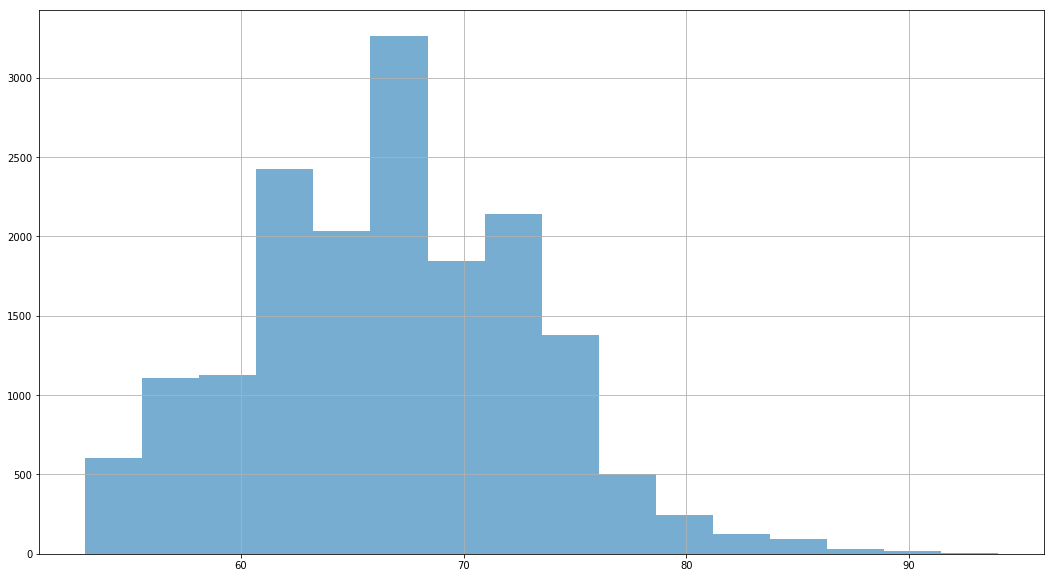

In [17]:
plt.figure(figsize=(18, 10))
plt.hist(ff18.Overall, bins=16, alpha=.6)
plt.grid(True)
plt.show()

In [18]:
# ff18.fillna(value=-99999, inplace=True)
# forecast_col = 'Overall'
# forecast_out = int(math.ceil(0.01 * len(ff18)))
# ff18['label'] = ff18[forecast_col].shift(-forecast_out)

In [19]:
# building our predictive model
train, test = train_test_split(ff18, test_size=0.2, random_state=99)
# xtrain = train[['ValueNum', 'Age', 'Potential', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']]
# ytrain = train[['Overall']]
# xtest = test[['ValueNum', 'Age', 'Potential', 'Finishing', 'Penalties', 'Aggression', 'Crossing', 'Stamina', 'Dribbling']]
# ytest = test[['Overall']]

xtrain = train[['ValueNum']]
ytrain = train[['Overall']]
xtest = test[['ValueNum']]
ytest = test[['Overall']]

In [20]:
# Linear Regression
clf = LinearRegression()
clf.fit(xtrain, ytrain)
lr_ypred = clf.predict(xtest)
print("Mean squared error: {:.2f}".format(mean_squared_error(ytest,lr_ypred)))
print("Variance core: {:.2f}".format(r2_score(ytest, lr_ypred)))

Mean squared error: 22.31
Variance core: 0.45


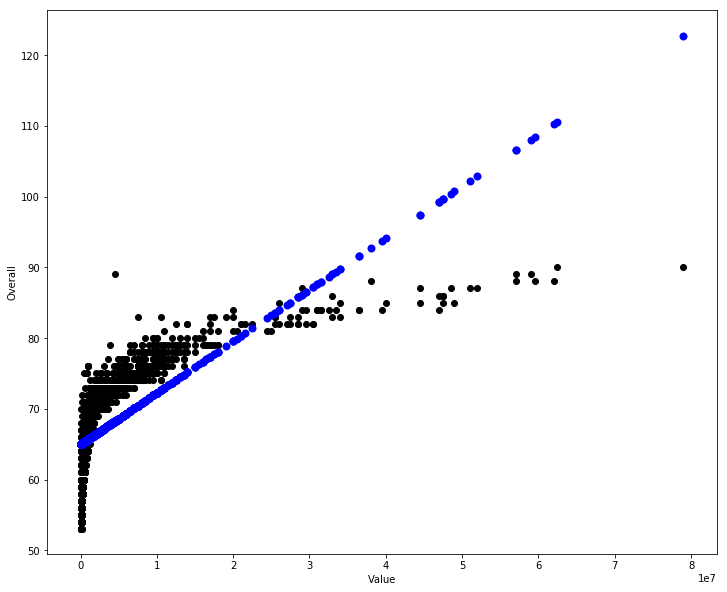

In [21]:
plt.figure(figsize=(12, 10))
plt.scatter(xtest['ValueNum'], ytest['Overall'], color='black')
plt.scatter(xtest['ValueNum'], lr_ypred, linewidth=2, color='blue')
plt.xlabel("Value")
plt.ylabel("Overall")
plt.show()

>This may seem like this model is not very good, but, in this case we can accept a model that produces a few bad predictions, with the most of them being good, then this model is not as bad as we thought. That’s because the predictions seem to be pretty accurate for those players with a value lower than €30M. Although it can not be appreciated very well in the plot, those players represent 98.97% of the total!

In [22]:
print("Players less than 30 Million Euro {:.2f}%".format(test.loc[test.ValueNum <= 30000000].ValueNum.count().astype('float') / test.ValueNum.count().astype('float') * 100))

Players less than 30 Million Euro 98.97%


In [24]:
# Polynomial interpolation and Ridge Regression
# Be patient this might take few minutes ;)
clf = make_pipeline(PolynomialFeatures(6), Ridge())
clf.fit(xtrain, ytrain)
pirg_ypred = clf.predict(xtest)
print("Mean squared error: {:.2f}".format(mean_squared_error(ytest,pirg_ypred)))
print("Variance core: {:.2f}".format(r2_score(ytest, pirg_ypred)))

Mean squared error: 9.21
Variance core: 0.77


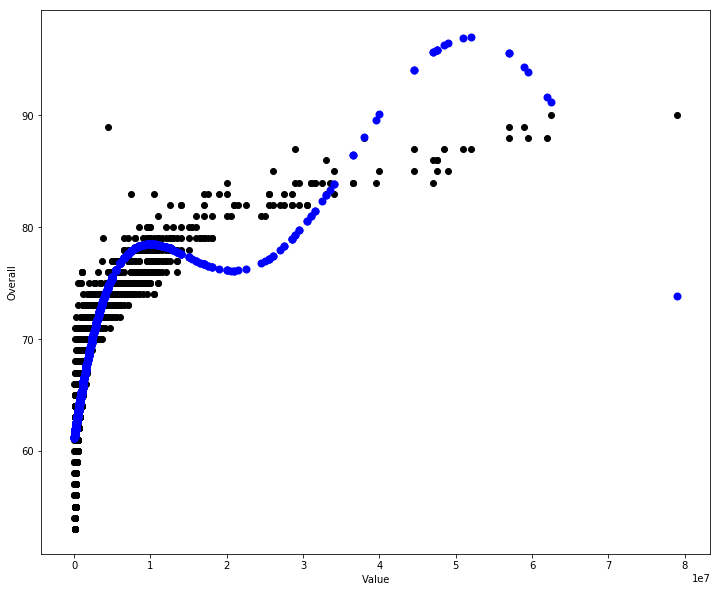

In [25]:
plt.figure(figsize=(12, 10))
plt.scatter(xtest['ValueNum'], ytest, color='black')
plt.scatter(xtest['ValueNum'], pirg_ypred, linewidth=2, color='blue')
plt.xlabel("Value")
plt.ylabel("Overall")
plt.show()

>Visually, the polynomial regression looks better than the standard linear regression.

In [26]:
# Support Vector Regression - RBF (radial basis function)
# Be patient this might take few minutes ;)
clf = svm.SVR(kernel='rbf', gamma=1e-3, C=100, epsilon=0.1)
clf.fit(xtrain, ytrain.values.ravel())
rbf_ypred = clf.predict(xtest)
print("Mean squared error: {:.2f}".format(mean_squared_error(ytest,rbf_ypred)))
print("Variance core: {:.2f}".format(r2_score(ytest, rbf_ypred)))

Mean squared error: 5.31
Variance core: 0.87


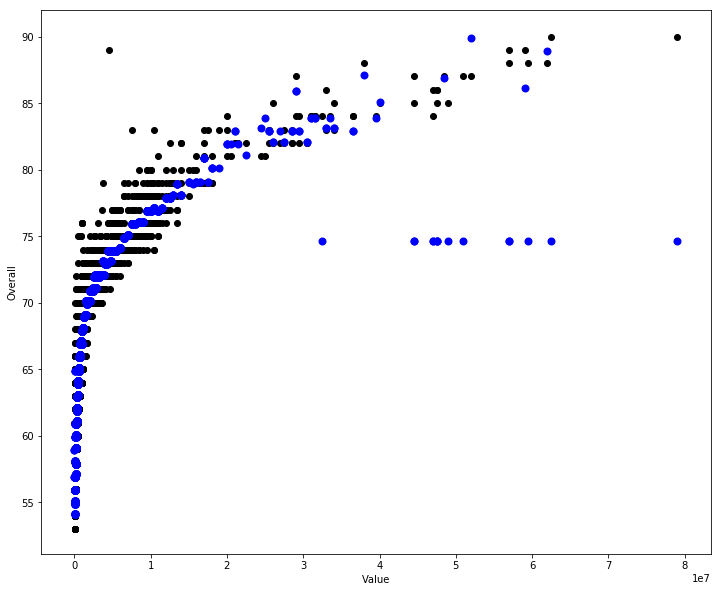

In [27]:
plt.figure(figsize=(12, 10))
plt.scatter(xtest['ValueNum'], ytest['Overall'], color='black')
plt.scatter(xtest['ValueNum'], rbf_ypred, linewidth=2, color='blue')
plt.xlabel("Value")
plt.ylabel("Overall")
plt.show()

In [28]:
pd.options.mode.chained_assignment = None
test['Overall_rbf'] = rbf_ypred
test['Error_PCT_rbf'] = np.abs((test.Overall - rbf_ypred) / test.Overall * 100)

test['Overall_pirg'] = pirg_ypred
test['Error_PCT_pirg'] = np.abs((test.Overall - [x[0] for x in pirg_ypred]) / test.Overall * 100)

test['Overall_lr'] = lr_ypred
test['Error_PCT_lr'] = np.abs((test.Overall - [x[0] for x in lr_ypred]) / test.Overall * 100)

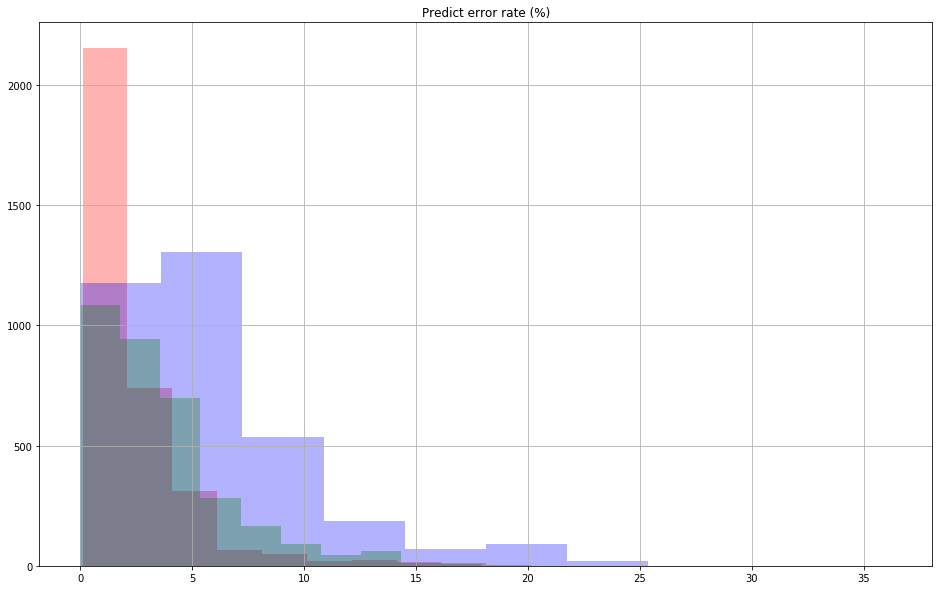

In [29]:
plt.figure(figsize=(16, 10))
kwargs = dict(histtype='stepfilled', alpha=0.3)
plt.hist(test.Error_PCT_rbf, color='r', **kwargs)
plt.hist(test.Error_PCT_lr, color='b', **kwargs)
plt.hist(test.Error_PCT_pirg, color='g', **kwargs)
plt.title("Predict error rate (%)")
plt.grid(True)
plt.show()

In [30]:
test[['Name', 
      'Club', 
      'Age', 
      'Value', 
      'Overall', 
      'Overall_rbf', 
      'Error_PCT_rbf', 
      'Overall_lr', 
      'Error_PCT_lr',
      'Overall_pirg',
      'Error_PCT_pirg'
     ]].nlargest(40, columns=['Error_PCT_rbf', 'Error_PCT_lr'])

,Name,Club,Age,Value,Overall,Overall_rbf,Error_PCT_rbf,Overall_lr,Error_PCT_lr,Overall_pirg,Error_PCT_pirg
9,T. Kroos,Real Madrid CF,27,€79M,90,74.621040,17.087733,122.615747,36.239719,73.873704,17.918107
21,N. Kanté,Chelsea,26,€59.5M,88,74.621040,15.203364,108.380439,23.159589,93.925357,6.733360
10,M. Hummels,FC Bayern Munich,28,€62.5M,90,74.621040,17.087733,110.570486,22.856096,91.172626,1.302918
29,E. Cavani,Paris Saint-Germain,30,€57M,88,74.621040,15.203364,106.555399,21.085681,95.605746,8.642894
45,M. Özil,Arsenal,28,€51M,87,74.621040,14.228690,102.175304,17.442879,96.928738,11.412343
57,T. Müller,FC Bayern Munich,27,€47.5M,86,74.621040,13.231349,99.620249,15.837499,95.889290,11.499174
55,C. Immobile,Lazio,27,€47.5M,86,74.621040,13.231349,99.620249,15.837499,95.889290,11.499174
52,Casemiro,Real Madrid CF,25,€47M,86,74.621040,13.231349,99.255241,15.413071,95.639945,11.209238
38,M. ter Stegen,FC Barcelona,25,€44.5M,87,74.621040,14.228690,97.430202,11.988738,94.058167,8.112836
6783,S. Rizzato,Avellino,35,€190K,68,57.899946,14.853020,65.083202,4.289409,61.953981,8.891204


In [31]:
test.loc[
    (test.Age > 21) 
    & (test.Age < 27)
    & (test.ValueNum < 30000000)
    & ((test.Error_PCT_lr < 3) & (test.Error_PCT_pirg < 3) & (test.Error_PCT_rbf < 3)), 
    [ 'Age', 
      'Value', 
      'Overall', 
      'Overall_rbf', 
      'Error_PCT_rbf', 
      'Overall_lr', 
      'Error_PCT_lr',
      'Overall_pirg',
      'Error_PCT_pirg']]

,Age,Value,Overall,Overall_rbf,Error_PCT_rbf,Overall_lr,Error_PCT_lr,Overall_pirg,Error_PCT_pirg
8320,24,€950K,67,67.899946,1.343204,65.638014,2.032815,65.164970,2.738850
9685,24,€850K,66,66.899946,1.363555,65.565012,0.659072,64.769629,1.864198
10319,23,€750K,65,66.099946,1.692225,65.492011,0.756940,64.366249,0.975001
10872,24,€550K,65,64.099946,1.384698,65.346008,0.532319,63.534967,2.253897
10580,26,€550K,65,64.099946,1.384698,65.346008,0.532319,63.534967,2.253897
10403,23,€700K,65,66.099946,1.692225,65.455510,0.700785,64.161513,1.289979
9393,25,€700K,66,66.099946,0.151434,65.455510,0.824985,64.161513,2.785586
8784,23,€950K,67,67.899946,1.343204,65.638014,2.032815,65.164970,2.738850
10968,23,€725K,65,65.899946,1.384533,65.473760,0.728862,64.264137,1.132098
11230,26,€400K,64,62.099946,2.968834,65.236505,1.932039,62.889645,1.734930
